# Clustering Abstract for 2010-2011

In [22]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import expr   
from pyspark.sql.functions import udf

from pyspark.sql import SparkSession
from pyspark import SparkFiles
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import StopWordsRemover

import matplotlib.pyplot as plt

from pyspark.ml.feature import HashingTF, IDF, Tokenizer, VectorAssembler
from pyspark.sql.functions import col

from pyspark.ml.feature import Word2Vec

#create a Spark application
spark = SparkSession.builder.enableHiveSupport().appName('eda').getOrCreate()
sc = spark.sparkContext
#spark.debug.maxToStringFields=60

#from pyspark.conf import SparkConf
spark.conf.set("spark.sql.debug.maxToStringFields", 500)

spark.sparkContext.uiWebUrl

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.stage.maxConsecutiveAttempts', '10'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.dataproc.sql.joinConditionReorder.enabled', 'true'),
 ('spark.executor.memory', '5739m'),
 ('spark.dataproc.sql.local.rank.pushdown.enabled', 'true'),
 ('spark.yarn.unmanagedAM.enabled', 'true'),
 ('spark.sql.autoBroadcastJoinThreshold', '43m'),
 ('spark.ui.filters',
  'org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter'),
 ('spark.driver.port', '46447'),
 ('spark.metrics.namespace',
  'app_name:${spark.app.name}.app_id:${spark.app.id}'),
 ('spark.dataproc.sql.optimizer.leftsemijoin.conversion.enabled', 'true'),
 ('spark.hadoop.hive.execution.engine', 'mr'),
 ('spark.executor.id', 'driver'),
 ('spark.app.name', 'PySparkShell'),
 ('spark.hadoop.mapreduce.fileoutputcommitter.algorithm.version', '2'),
 ('spark.dynamicAllocation.maxExecutors', '10000'),
 ('spark.yarn.am.attemptFailuresValidityInterval', '1h'),
 ('spark.sql.catalogImplementatio

In [23]:
df = spark.read.parquet('gs://msca-bdp-student-gcs/Group5_Final_Project/raw_data/dhruv_par.parquet')

In [24]:
df_new = df.select(df.fos[0].getItem('name'), df.authors[0].getItem('name'), df.abstract, df.title, df.year)

df_new = df_new.withColumnRenamed("fos[0].name","category")\
    .withColumnRenamed("authors[0].name","author_name")


# dropping rows with na in any column
df_new = df_new.dropna()

In [25]:
year_list = [2018]
df_read = df_new.filter(df_new.year.isin(year_list)) #count = 2235775
df_read = df_read.dropna()
df_read.count()

235937

### Cleaning abstract

In [26]:
#removing rows where abstract is empty

df_read = df_read.filter("abstract != ''")

df_read = df_read.filter(trim(col("abstract")) != "null")

#remove all the abstracts which are duplicate
abstracts_to_remove = df_read.groupBy("abstract").count().orderBy(col("count")).filter(col("count")>1)
abstracts_remove_list = abstracts_to_remove.rdd.map(lambda x: x[0]).collect()
df_read = df_read.filter(~df_read.abstract.isin(abstracts_remove_list))

#trim whitespace
df_read = df_read.withColumn("abstract", trim(df.abstract))
#remove redundant space between words
df_read = df_read.withColumn("abstract", regexp_replace("abstract", "\s+", " "))
#remove punctuation marks
df_read = df_read.withColumn("abstract", regexp_replace("abstract", "[^\\w\\s]+", ""))
df_read = df_read.filter("abstract != ''")


In [27]:
df_read.count()

217732

### Tokenizer

In [28]:
tokenizer = Tokenizer(inputCol="abstract", outputCol="words")
df_read = tokenizer.transform(df_read)
#remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
df_read = remover.transform(df_read)

#drop the redundant source column
df_read= df_read.drop("words")

### Vectorizer

In [29]:
vec_size = 50
word2Vec = Word2Vec(vectorSize=vec_size, minCount=0, inputCol="filtered", outputCol="wordVectors")

In [30]:
w2VM = word2Vec.fit(df_read)
nlpdf = w2VM.transform(df_read)
nlpdf.select(col("wordVectors")).show()

+--------------------+
|         wordVectors|
+--------------------+
|[-0.0798618344626...|
|[0.06761593334164...|
|[0.14266425330886...|
|[0.14202184200015...|
|[0.10074390927819...|
|[0.13432700641418...|
|[0.05263412052299...|
|[0.07252279360566...|
|[0.05142633373970...|
|[-0.1269916308269...|
|[-0.0333167653202...|
|[-0.0230874914055...|
|[-0.0174039671063...|
|[-0.0225365707318...|
|[-0.0293591263503...|
|[0.01216974440030...|
|[0.01402576041712...|
|[0.05802745500386...|
|[0.16447770543569...|
|[0.05533661675040...|
+--------------------+
only showing top 20 rows



In [31]:
from pyspark.ml.functions import vector_to_array
nlpdf_new = nlpdf.withColumn("vec", vector_to_array("wordVectors")).select(["category", "author_name", "year"] + [col("vec")[i] for i in range(vec_size)])
nlpdf_new.printSchema()

root
 |-- category: string (nullable = true)
 |-- author_name: string (nullable = true)
 |-- year: long (nullable = true)
 |-- vec[0]: double (nullable = true)
 |-- vec[1]: double (nullable = true)
 |-- vec[2]: double (nullable = true)
 |-- vec[3]: double (nullable = true)
 |-- vec[4]: double (nullable = true)
 |-- vec[5]: double (nullable = true)
 |-- vec[6]: double (nullable = true)
 |-- vec[7]: double (nullable = true)
 |-- vec[8]: double (nullable = true)
 |-- vec[9]: double (nullable = true)
 |-- vec[10]: double (nullable = true)
 |-- vec[11]: double (nullable = true)
 |-- vec[12]: double (nullable = true)
 |-- vec[13]: double (nullable = true)
 |-- vec[14]: double (nullable = true)
 |-- vec[15]: double (nullable = true)
 |-- vec[16]: double (nullable = true)
 |-- vec[17]: double (nullable = true)
 |-- vec[18]: double (nullable = true)
 |-- vec[19]: double (nullable = true)
 |-- vec[20]: double (nullable = true)
 |-- vec[21]: double (nullable = true)
 |-- vec[22]: double (nullable

### Calculating the silhouette score

In [32]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, VectorAssembler

column_names = []
for i in range (vec_size):
    col_name = "vec[{}]".format(i)
    column_names.append(col_name)

vecAssembler = VectorAssembler(inputCols = column_names, outputCol="features")
new_df = vecAssembler.transform(nlpdf_new)

In [ ]:
silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='features', \
metricName='silhouette', distanceMeasure='squaredEuclidean')

for K in range(2,11):

    KMeans_=KMeans(featuresCol='features', k=K)

    KMeans_fit=KMeans_.fit(new_df)

    KMeans_transform=KMeans_fit.transform(new_df) 

    evaluation_score=evaluator.evaluate(KMeans_transform)

    silhouette_scores.append(evaluation_score)
    

Text(0, 0.5, 'Silhouette Score')

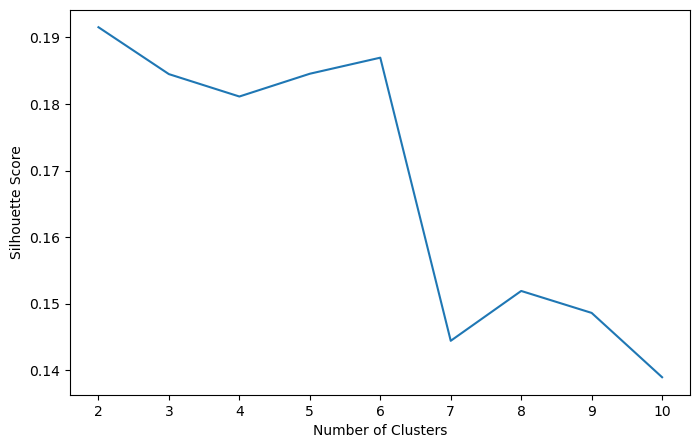

In [34]:
fig, ax = plt.subplots(1,1, figsize =(8,5))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

### Clustering

In [35]:
from pyspark.ml.clustering import KMeans
num_clusters = 10
kmeans = KMeans(k=num_clusters, seed=1)
model = kmeans.fit(new_df.select('features'))
transformed = model.transform(new_df)
transformed.select(col("prediction")).show(10)

+----------+
|prediction|
+----------+
|         2|
|         1|
|         8|
|         8|
|         5|
|         8|
|         8|
|         8|
|         2|
|         2|
+----------+
only showing top 10 rows



### Group by category and cluster prediction

In [36]:
transformed.printSchema()
df_agg = transformed.groupBy("category", "prediction").count()
df_agg.show(10)

root
 |-- category: string (nullable = true)
 |-- author_name: string (nullable = true)
 |-- year: long (nullable = true)
 |-- vec[0]: double (nullable = true)
 |-- vec[1]: double (nullable = true)
 |-- vec[2]: double (nullable = true)
 |-- vec[3]: double (nullable = true)
 |-- vec[4]: double (nullable = true)
 |-- vec[5]: double (nullable = true)
 |-- vec[6]: double (nullable = true)
 |-- vec[7]: double (nullable = true)
 |-- vec[8]: double (nullable = true)
 |-- vec[9]: double (nullable = true)
 |-- vec[10]: double (nullable = true)
 |-- vec[11]: double (nullable = true)
 |-- vec[12]: double (nullable = true)
 |-- vec[13]: double (nullable = true)
 |-- vec[14]: double (nullable = true)
 |-- vec[15]: double (nullable = true)
 |-- vec[16]: double (nullable = true)
 |-- vec[17]: double (nullable = true)
 |-- vec[18]: double (nullable = true)
 |-- vec[19]: double (nullable = true)
 |-- vec[20]: double (nullable = true)
 |-- vec[21]: double (nullable = true)
 |-- vec[22]: double (nullable

+--------------------+----------+-----+
|            category|prediction|count|
+--------------------+----------+-----+
|Automotive engine...|         0|   97|
|     Electrical load|         0|    3|
|       Data modeling|         9|   70|
|      Optical switch|         3|    4|
|Information techn...|         9|   40|
|      Financial risk|         9|   20|
|Upper and lower b...|         2|    5|
|     Noise reduction|         8|   71|
|Biomedical engine...|         4|  436|
|    Computer science|         0| 1953|
+--------------------+----------+-----+
only showing top 10 rows



### Getting top 5 categories in each cluster

In [37]:
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col

window = Window.partitionBy(df_agg['prediction']).orderBy(df_agg['count'].desc())
df_short = df_agg.select('*', rank().over(window).alias('rank')).filter(col('rank') <= 5) 

In [38]:
df_short.show(100)

+--------------------+----------+-----+----+
|            category|prediction|count|rank|
+--------------------+----------+-----+----+
|Discrete mathematics|         1| 2530|   1|
|             Integer|         1|  548|   2|
|               Graph|         1|  510|   3|
|       Combinatorics|         1|  257|   4|
|Prime (order theory)|         1|  107|   5|
|        Base station|         6|  652|   1|
|    Computer science|         6|  558|   2|
|         Transmitter|         6|  484|   3|
|    Wireless network|         6|  422|   4|
|            Wireless|         6|  408|   5|
|      Control theory|         3|  567|   1|
|    Computer science|         3|  407|   2|
|            Inverter|         3|  343|   3|
|           Capacitor|         3|  203|   4|
|Automotive engine...|         3|  181|   5|
|     Computer vision|         5| 5481|   1|
| Pattern recognition|         5| 1569|   2|
|         Data mining|         5| 1203|   3|
|    Computer science|         5|  825|   4|
|Kernel (l

We can see that these results are cosistent with the results we got in 2010-2011. We can see healthcare and social psychology interacting with data science and computer science. We can also see a very new cluster that contains- Internet privacy, Humanities, Knowledge Managemet, Computer security and gynecology. It would be interesting to dig deep into each of these fields and study how they are interacting with each other. 

### Save the results

In [21]:
df_short.repartition(1).write.option("header",True).csv("gs://msca-bdp-student-gcs/Group5_Final_Project/raw_data/dhruv_res_prelim/2017_short.csv")
df_agg.repartition(1).write.option("header",True).csv("gs://msca-bdp-student-gcs/Group5_Final_Project/raw_data/dhruv_res_prelim/2017_agg.csv")

In [39]:
df_short.repartition(1).write.option("header",True).csv("gs://msca-bdp-student-gcs/Group5_Final_Project/raw_data/dhruv_res_prelim/2017_short_revised.csv")